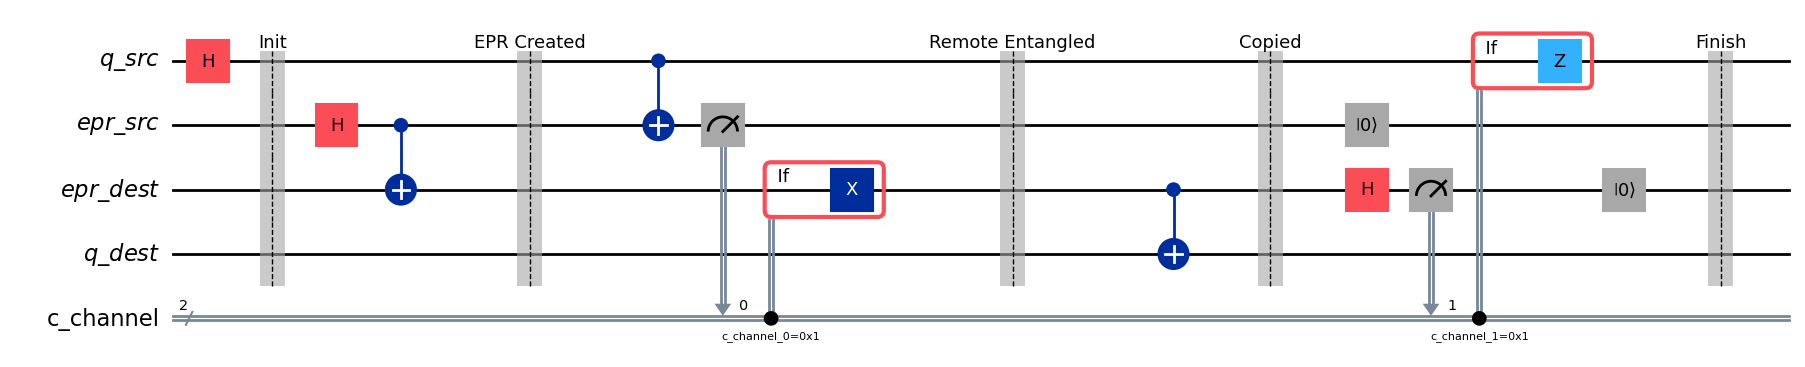

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# 1. Setup Register
# Node A (Source)
src_data = QuantumRegister(1, 'q_src')       # ข้อมูลต้นฉบับ
src_epr  = QuantumRegister(1, 'epr_src')     # สายสื่อสารฝั่งส่ง

# Node B (Dest)
dest_epr = QuantumRegister(1, 'epr_dest')    # สายสื่อสารฝั่งรับ
dest_data = QuantumRegister(1, 'q_dest')     # qubit ปลายทางที่จะรับ copy

# Classical Channel (สำหรับการส่งผล Measure)
creg = ClassicalRegister(2, 'c_channel')

qc = QuantumCircuit(src_data, src_epr, dest_epr, dest_data, creg)

# ==========================================
# 0. State Preparation (สมมติให้ Src เป็นสถานะ |+>)
# ==========================================
qc.h(src_data) 
qc.barrier(label='Init')

# ==========================================
# Phase 1: Establish Connection (EPR Pair)
# ==========================================
# สร้าง EPR ระหว่าง Node A กับ Node B (ส่วนหนึ่งของฟังก์ชัน makeEPRPair)
qc.h(src_epr)
qc.cx(src_epr, dest_epr)
qc.barrier(label='EPR Created')

# ==========================================
# Phase 2: "COPY" (Send CNOT Control)
# อ้างอิงจากฟังก์ชัน copy() ใน MPI.py
# ==========================================
# Alice ทำ CNOT ใส่ epr ของตัวเอง
qc.cx(src_data, src_epr)

# วัดค่า epr ฝั่ง Alice เพื่อส่งไปแก้ที่ Bob
qc.measure(src_epr, creg[0])

# Bob แก้ไขสถานะตามผลวัด (Feedforward)
with qc.if_test((creg[0], 1)):
    qc.x(dest_epr)

# ณ จุดนี้: src_data พัวพันกับ dest_epr แล้ว
qc.barrier(label='Remote Entangled')

# ==========================================
# Phase 3: "LOCAL CNOT" (Fan-out)
# อ้างอิงจากฟังก์ชัน cnot() ใน MPI.py
# ==========================================
# Bob ใช้ dest_epr (ที่เป็นตัวแทนของ src) มา control ใส่ qubit ปลายทาง
qc.cx(dest_epr, dest_data)

# ณ จุดนี้: Copy เสร็จสมบูรณ์ (เป็น GHZ State ระหว่าง Src, Dest_EPR, Dest_Data)
qc.barrier(label='Copied')

# ==========================================
# Phase 4: "UNCOPY" (Disentangle Link)
# อ้างอิงจากฟังก์ชัน uncopy() ใน MPI.py
# ==========================================
# ล้าง dest_epr ออก เพื่อให้เหลือแค่ Src กับ Dest ที่พัวพันกัน
qc.h(dest_epr)
qc.measure(dest_epr, creg[1])

# แก้ Phase กลับไปที่ต้นทาง (Phase Kickback correction)
with qc.if_test((creg[1], 1)):
    qc.z(src_data)

# Reset EPR เพื่อนำไปใช้ใหม่ (ในโค้ด MPI มีบรรทัดนี้)
qc.reset(src_epr)
qc.reset(dest_epr)

qc.barrier(label='Finish')

# วาดวงจร
qc.draw("mpl")

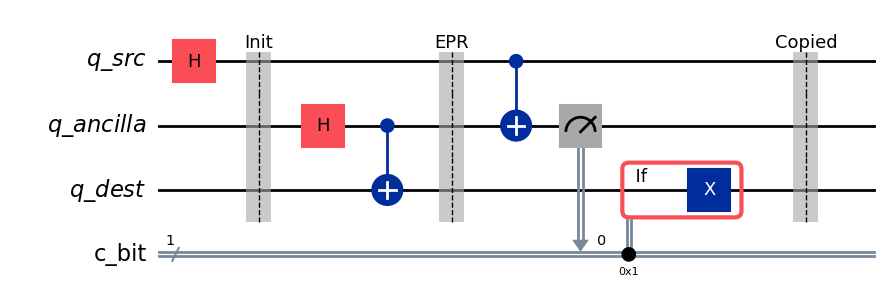

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# กำหนด Register
# 1. Source Data (Alice)
src = QuantumRegister(1, 'q_src')

# 2. Shared EPR Pair
# Alice ถือ epr_src (ancilla)
# Bob ถือ dest (ซึ่งเป็นครึ่งหนึ่งของ EPR และจะเป็นตัวเก็บข้อมูลด้วย)
epr_src = QuantumRegister(1, 'q_ancilla') 
dest = QuantumRegister(1, 'q_dest')

# Classical Register สำหรับวัดผล
cr = ClassicalRegister(1, 'c_bit')

qc = QuantumCircuit(src, epr_src, dest, cr)

# ==========================================
# 0. เตรียมสถานะเริ่มต้นให้ Source (สมมติเป็น |+>)
# ==========================================
qc.h(src)
qc.barrier(label='Init')

# ==========================================
# 1. สร้าง EPR Pair (ระหว่าง Alice กับ Bob)
# ==========================================
qc.h(epr_src)
qc.cx(epr_src, dest)
# ตอนนี้ epr_src กับ dest พัวพันกันแล้ว
qc.barrier(label='EPR')

# ==========================================
# 2. Copy / Fan-out (Cat_Comm Protocol)
# ==========================================
# Alice ทำ CNOT จากข้อมูลตัวเอง ใส่ epr_src
qc.cx(src, epr_src)

# Alice วัดค่า epr_src แล้วส่งผลไปให้ Bob
qc.measure(epr_src, cr)

# Bob แก้สถานะตามผลวัด (ถ้าได้ 1 ให้พลิกกลับ)
with qc.if_test((cr, 1)):
    qc.x(dest)

# ==========================================
# จบ: ตอนนี้ src และ dest มีค่าเหมือนกัน (Entangled)
# ==========================================
qc.barrier(label='Copied')

qc.draw("mpl")

In [3]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector
import numpy as np

# 1️⃣ ลบการวัดออก (เพื่อดูสถานะก่อน collapse)
circ_no_measure = qc.remove_final_measurements(inplace=False)

# 2️⃣ บอกให้ simulator เก็บ statevector
circ_no_measure.save_statevector() 

# 3️⃣ ใช้ simulator แบบ statevector
sim_sv = AerSimulator(method='statevector')

# 4️⃣ transpile และรัน
ready_sv = transpile(circ_no_measure, sim_sv)
result_sv = sim_sv.run(ready_sv).result()

# 5️⃣ ดึงข้อมูล statevector ออกมา
statevector = result_sv.data(0)['statevector']
# print(statevector)

# statevector จากผล simulation
vec = Statevector(statevector)

# แสดงเฉพาะค่าสำคัญ
for i, amp in enumerate(vec.data):
    if not np.isclose(abs(amp), 0):  # ข้ามค่าที่แทบเป็นศูนย์
        print(f"|{i:0{vec.num_qubits}b}> : {amp}")

|0000> : (0.7071067811865476+0j)
|1001> : (0.7071067811865475-8.659560562354932e-17j)
